In [37]:
import pandas as pd
import os
from dateutil import parser

# 1. 年份和媒体列表
years = list(range(2015, 2026))
media_sources = ["abc", "msnbc", "fox"]

# 2. 读取并拼接
all_dfs = []

for media in media_sources:
    for year in years:
        path = f"../data/{media}/{media}{year}.csv"
        if os.path.exists(path):
            try:
                df = pd.read_csv(path, on_bad_lines="skip")
                df["media"] = media
                df["year_file"] = year
                all_dfs.append(df)
            except Exception as e:
                print(f"❌ Failed to read {path}: {e}")
        else:
            print(f"⚠️ File not found: {path}")

# 合并为一个总表
df_all = pd.concat(all_dfs, ignore_index=True)

# 3. 安全解析 parsed_date
def safe_parse(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

df_all["parsed_date"] = df_all["parsed_date"].apply(safe_parse)
df_all = df_all.dropna(subset=["parsed_date"])
df_all["parsed_date"] = pd.to_datetime(df_all["parsed_date"], errors="coerce", utc=True)
# df_all = df_all.dropna(subset=["parsed_date"])

# 4. 提取 V2Tone 第一项为 gdelt_tone
df_all = df_all[df_all["V2Tone"].notna()]
df_all = df_all[df_all["V2Tone"].str.contains(",", na=False)]

df_all["gdelt_tone"] = pd.to_numeric(
    df_all["V2Tone"].str.split(",", expand=True)[0],
    errors="coerce"
)
df_all = df_all.dropna(subset=["gdelt_tone"])

# 5. 添加时间字段
df_all["month"] = df_all["parsed_date"].dt.to_period("M").astype(str)
df_all["week"] = df_all["parsed_date"].dt.to_period("W").astype(str)
df_all["year"] = df_all["parsed_date"].dt.year

# 6. 展示结果
print("✅ 成功读取并处理数据，共有行数：", len(df_all))
print(df_all[["media", "parsed_date", "month", "week", "year", "gdelt_tone"]].head())


C:\Users\Michael\AppData\Local\Temp\ipykernel_17044\4167548596.py:52: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_all["month"] = df_all["parsed_date"].dt.to_period("M").astype(str)
C:\Users\Michael\AppData\Local\Temp\ipykernel_17044\4167548596.py:53: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_all["week"] = df_all["parsed_date"].dt.to_period("W").astype(str)


✅ 成功读取并处理数据，共有行数： 330869
  media               parsed_date    month                   week  year  \
0   abc 2015-02-18 22:15:00+00:00  2015-02  2015-02-16/2015-02-22  2015   
1   abc 2015-02-18 22:30:00+00:00  2015-02  2015-02-16/2015-02-22  2015   
2   abc 2015-02-18 22:30:00+00:00  2015-02  2015-02-16/2015-02-22  2015   
3   abc 2015-02-18 22:30:00+00:00  2015-02  2015-02-16/2015-02-22  2015   
4   abc 2015-02-18 22:30:00+00:00  2015-02  2015-02-16/2015-02-22  2015   

   gdelt_tone  
0   -8.148148  
1   -3.533569  
2   -0.392157  
3   -8.235294  
4   -9.178744  


In [38]:
# 只看 2016 年的数据
df_2016 = df_all[df_all["year"] == 2016]

# 查看各媒体数据量
print("📊 每个媒体在 2016 年的数据条数：")
print(df_2016["media"].value_counts())

# 查看每个媒体的前三条记录（含情绪得分和时间）
print("\n📋 各媒体 2016 年前三条记录：")
print(df_2016.groupby("media").head(3)[["media", "parsed_date", "month", "week", "gdelt_tone"]])


📊 每个媒体在 2016 年的数据条数：
media
abc      12000
fox      12000
msnbc     5339
Name: count, dtype: int64

📋 各媒体 2016 年前三条记录：
        media               parsed_date    month                   week  \
11000     abc 2016-01-01 02:30:00+00:00  2016-01  2015-12-28/2016-01-03   
11001     abc 2016-01-01 03:15:00+00:00  2016-01  2015-12-28/2016-01-03   
11002     abc 2016-01-01 05:45:00+00:00  2016-01  2015-12-28/2016-01-03   
129345  msnbc 2016-01-01 14:00:00+00:00  2016-01  2015-12-28/2016-01-03   
129346  msnbc 2016-01-01 14:45:00+00:00  2016-01  2015-12-28/2016-01-03   
129347  msnbc 2016-01-01 14:45:00+00:00  2016-01  2015-12-28/2016-01-03   
219790    fox 2016-01-01 00:15:00+00:00  2016-01  2015-12-28/2016-01-03   
219791    fox 2016-01-01 02:45:00+00:00  2016-01  2015-12-28/2016-01-03   
219792    fox 2016-01-01 05:45:00+00:00  2016-01  2015-12-28/2016-01-03   

        gdelt_tone  
11000    -5.921053  
11001    -6.887755  
11002    -3.676471  
129345   -0.356506  
129346   -2.741228  
12934

In [43]:

# 年均
tone_yearly = df_all.groupby(["media", "year"])["gdelt_tone"].mean().reset_index()
tone_yearly.to_csv("../data/tone_by_year.csv", index=False)

# 月均
tone_monthly = df_all.groupby(["media", "month"])["gdelt_tone"].mean().reset_index()
tone_monthly.to_csv("../data/tone_by_month.csv", index=False)

# 周均
tone_weekly = df_all.groupby(["media", "week"])["gdelt_tone"].mean().reset_index()
tone_weekly.to_csv("../data/tone_by_week.csv", index=False)


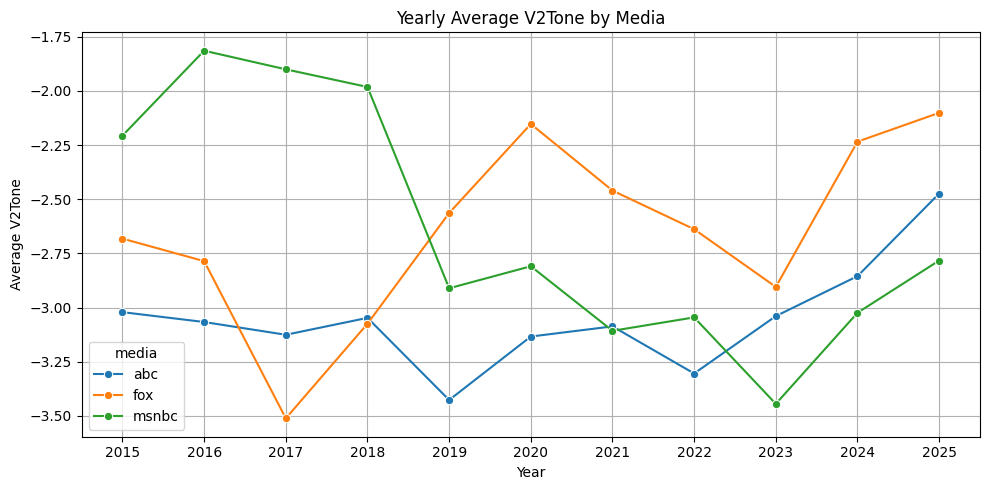

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=tone_yearly, x="year", y="gdelt_tone", hue="media", marker="o")
plt.title("Yearly Average V2Tone by Media")
plt.ylabel("Average V2Tone")
plt.xlabel("Year")
plt.xticks(tone_yearly["year"].unique())
plt.grid(True)
plt.tight_layout()
plt.show()


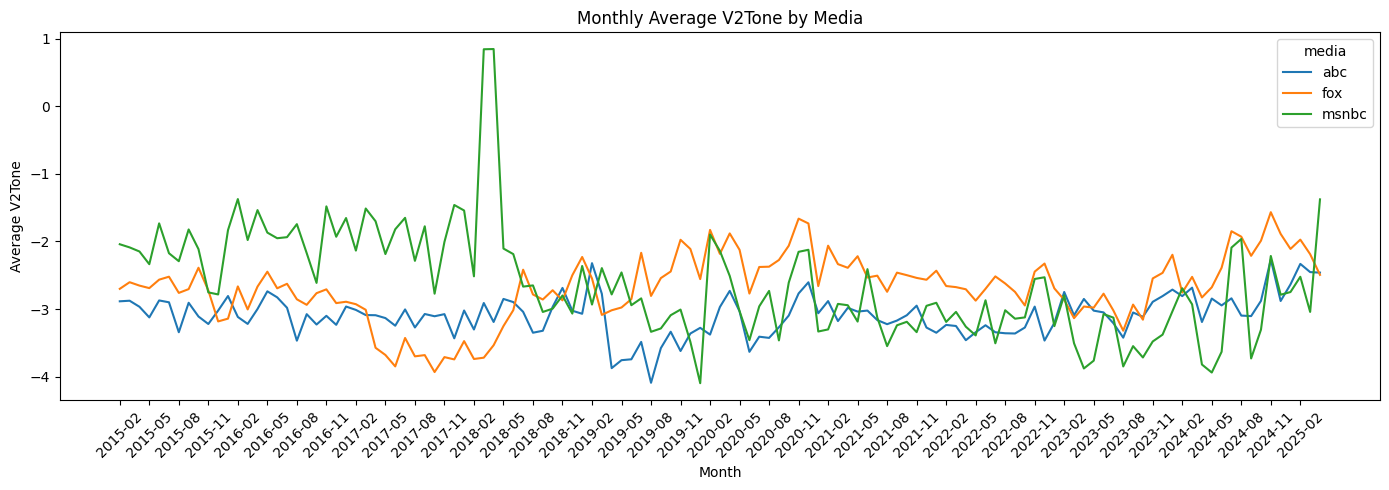

In [47]:
plt.figure(figsize=(14, 5))
ax = sns.lineplot(data=tone_monthly, x="month", y="gdelt_tone", hue="media")
plt.title("Monthly Average V2Tone by Media")
plt.ylabel("Average V2Tone")
plt.xlabel("Month")

# 设置 xticks 每 3 个取一个
xticks = tone_monthly["month"].unique()
plt.xticks(ticks=xticks[::3], rotation=45)

plt.tight_layout()
plt.show()


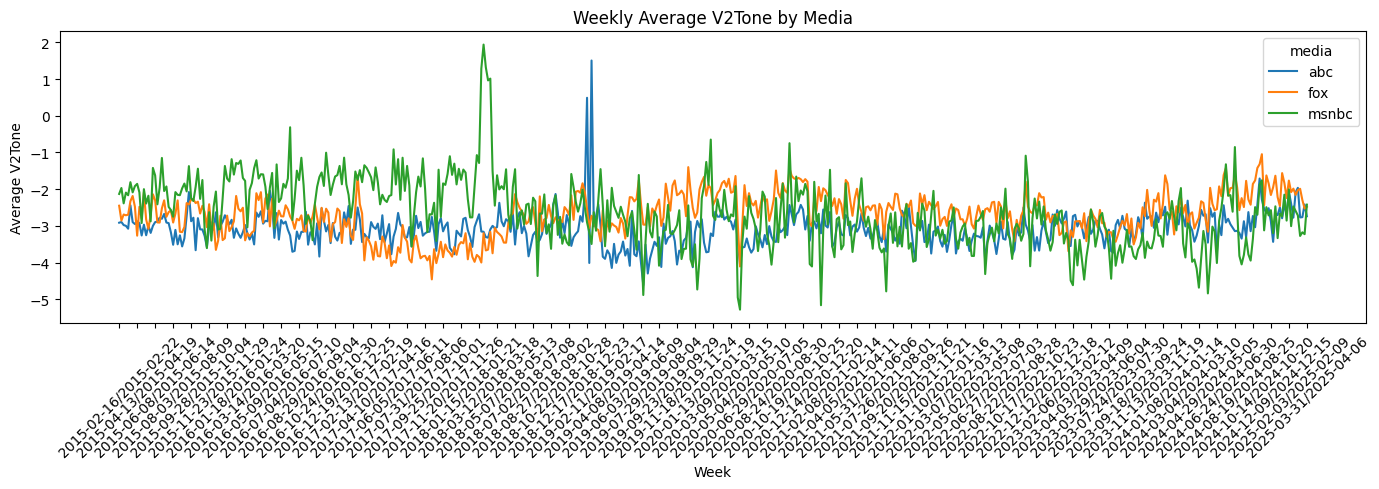

In [48]:
plt.figure(figsize=(14, 5))
ax = sns.lineplot(data=tone_weekly, x="week", y="gdelt_tone", hue="media")
plt.title("Weekly Average V2Tone by Media")
plt.ylabel("Average V2Tone")
plt.xlabel("Week")

# 设置 xticks 每 8 周取一个
xticks = tone_weekly["week"].unique()
plt.xticks(ticks=xticks[::8], rotation=45)

plt.tight_layout()
plt.show()
